Class distribution:
 loan_status
0    2656
1    1613
Name: count, dtype: int64
Random Forest Accuracy: 0.9831
Random Forest ROC AUC:  0.9987
OOB Score (train):      0.9769

Confusion Matrix:
[[659   5]
 [ 13 391]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       664
           1       0.99      0.97      0.98       404

    accuracy                           0.98      1068
   macro avg       0.98      0.98      0.98      1068
weighted avg       0.98      0.98      0.98      1068



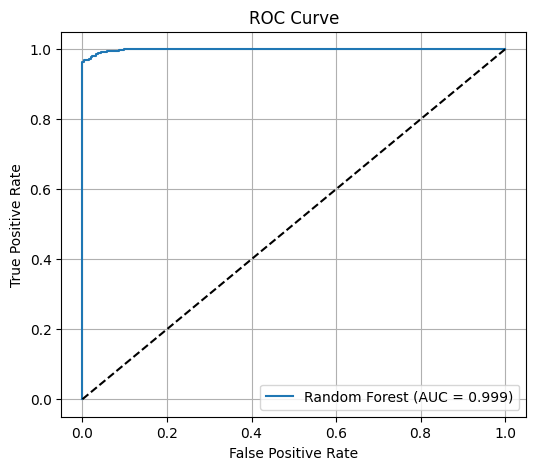


Top feature importances:
cibil_score                 0.826812
loan_term                   0.059601
loan_amount                 0.024429
loan_id                     0.014363
income_annum                0.013881
luxury_assets_value         0.013783
residential_assets_value    0.013166
commercial_assets_value     0.012848
bank_asset_value            0.011657
no_of_dependents            0.005868
self_employed               0.002008
education                   0.001583
dtype: float64


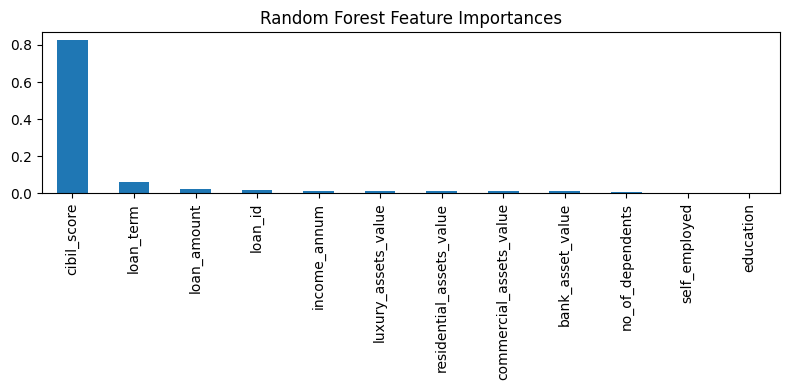


Saved model to rf_loan_model.joblib


In [1]:
# Random Forest classifier pipeline
# Requirements: pip install scikit-learn pandas matplotlib joblib

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings("ignore")

# 1) Load cleaned dataset
df = pd.read_csv("cleaned_loan_data.csv")   # replace path if needed

# 2) Split features & target
X = df.drop("loan_status", axis=1)
y = df["loan_status"]

# Optional: check class balance
print("Class distribution:\n", y.value_counts())

# 3) Train-test split (stratify to preserve class ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# 4) Base Random Forest model (good default)
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=3,
    n_jobs=-1,
    random_state=42,
    oob_score=True   # useful for quick OOB estimate
)

# Fit
rf.fit(X_train, y_train)

# 5) Predict & Evaluate
y_pred = rf.predict(X_test)
if hasattr(rf, "predict_proba"):
    y_proba = rf.predict_proba(X_test)[:, 1]
else:
    # fallback if predict_proba not available
    y_proba = rf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"Random Forest Accuracy: {acc:.4f}")
print(f"Random Forest ROC AUC:  {roc_auc:.4f}")
print(f"OOB Score (train):      {rf.oob_score_:.4f}" if hasattr(rf, "oob_score_") else "")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 6) ROC Curve (plot)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# 7) Feature Importance
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop feature importances:")
print(feat_imp)

plt.figure(figsize=(8,4))
feat_imp.plot(kind="bar")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

# 8) Save the model
joblib.dump(rf, "rf_loan_model.joblib")
print("\nSaved model to rf_loan_model.joblib")


# ------------------------------
# Optional: Hyperparameter tuning (GridSearchCV)
# ------------------------------
do_tune = False   # set True to run tuning (can be slow)
if do_tune:
    param_grid = {
        "n_estimators": [100, 200, 400],
        "max_depth": [None, 6, 10],
        "min_samples_leaf": [1, 3, 5],
        "max_features": ["sqrt", "log2", 0.8]
    }

    gs = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
        param_grid=param_grid,
        scoring="roc_auc",
        cv=4,
        verbose=1
    )
    gs.fit(X_train, y_train)
    print("Best params:", gs.best_params_)
    best_rf = gs.best_estimator_

    # Evaluate best estimator
    y_pred_best = best_rf.predict(X_test)
    y_proba_best = best_rf.predict_proba(X_test)[:, 1]
    print("Tuned RF Accuracy:", accuracy_score(y_test, y_pred_best))
    print("Tuned RF ROC AUC:", roc_auc_score(y_test, y_proba_best))
    joblib.dump(best_rf, "rf_loan_model_tuned.joblib")
    print("Saved tuned model to rf_loan_model_tuned.joblib")
